In [4]:
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import logical_and as land, logical_or as lor
import re
from utilities import plot_boxplot, plot_hist

In [33]:
DATA_PATH = 'G:/Shared drives/DM_tweets/data/'

In [2]:
DATA_PATH = 'G:/Drive condivisi/DM_tweets/data/'

In [3]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_clean.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')

# How many tweets were published by the user?

In [5]:
df_indicators = pd.DataFrame({'n_tweets' : df_tweets.groupby(['user_id'] ).size()}).reset_index()

In [6]:
df_indicators

,user_id,n_tweets
0,000vk,1
1,0013tom,1
2,001gi,1
3,001rx,1
4,00201f,1
...,...,...
140538,zzyb,1
140539,zzyd6,1
140540,zzyyu,1
140541,zzz9v,1


# How many tweets are published by the user in a given period of time?

In [7]:
for y in range(2012, 2021):
  df_indicators[str(y) + "_tweets"] = 0

df_indicators

,user_id,n_tweets,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,2018_tweets,2019_tweets,2020_tweets
0,000vk,1,0,0,0,0,0,0,0,0,0
1,0013tom,1,0,0,0,0,0,0,0,0,0
2,001gi,1,0,0,0,0,0,0,0,0,0
3,001rx,1,0,0,0,0,0,0,0,0,0
4,00201f,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
140538,zzyb,1,0,0,0,0,0,0,0,0,0
140539,zzyd6,1,0,0,0,0,0,0,0,0,0
140540,zzyyu,1,0,0,0,0,0,0,0,0,0
140541,zzz9v,1,0,0,0,0,0,0,0,0,0


In [8]:
for y in range(2012,2021):
  # Filter all tweets published in a certain year
  tweets_by_y = df_tweets[land(df_tweets['created_at'] >= (str(y)+"-01-01"), 
                               df_tweets['created_at'] <= (str(y)+"-12-31"))][['user_id','created_at']]

  # Count tweets of users in that year
  gby = pd.DataFrame({'n_tweets' : tweets_by_y.groupby( [ 'user_id'] ).size()}).reset_index()
  
  # Transform it in a dictionary
  gby = dict(zip(gby.user_id, gby.n_tweets))

  # Select users to modify and update them
  df_indicators.loc[df_indicators['user_id'].isin(gby.keys()), str(y)+'_tweets'] = list(gby.values())

<BarContainer object of 9 artists>

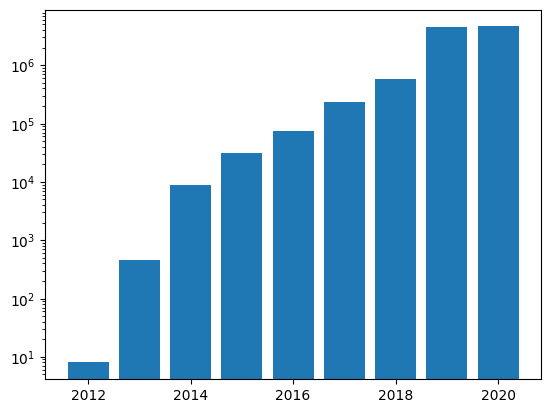

In [9]:
years_col_list = [str(y)+'_tweets' for y in range(2012,2021)]
sum_list = [df_indicators[y].sum() for y in years_col_list]
plt.bar(range(2012,2021), sum_list, log=True)

# Total number of tweets

In [10]:
tot_n_tweets = df_tweets.shape[0]
tot_n_tweets

10187873

# Total number of likes and comments and retweets

In [11]:
total_favorite = df_tweets.favorite_count.sum()
total_favorite

6086511

In [12]:
total_replies = df_tweets.reply_count.sum()
total_replies

68390

In [13]:
total_retweets = df_tweets.retweet_count.sum()
total_retweets

629579008

# Ratio between the number of tweets and the number of likes

In [14]:
ratio_tweets_fav = len(df_tweets) / total_favorite
ratio_tweets_fav

1.6738445063189733

## Ratio between the number of tweets and the number of retweets

In [15]:
ratio_tweets_rt = len(df_tweets) / total_retweets
ratio_tweets_rt

0.01618204049141359

## Ratio between the number of tweets and the number of comments

In [16]:
ratio_tweets_replies = len(df_tweets) / total_replies
ratio_tweets_replies

148.96729053955258

# Average length of the tweets per user

In [17]:
df_tweets['length'] = df_tweets.text.astype(str).apply(len)

<AxesSubplot: >

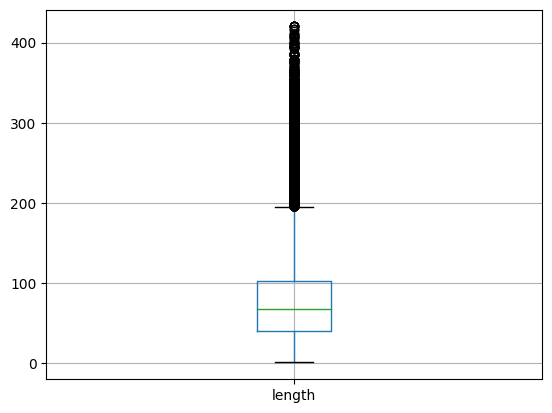

In [18]:
df_tweets.boxplot('length')

In [19]:
len_groupby = df_tweets.groupby('user_id').agg({'length':'mean'})

In [20]:
df_indicators['mean_length'] = len_groupby.length.values
df_indicators

,user_id,n_tweets,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,2018_tweets,2019_tweets,2020_tweets,mean_length
0,000vk,1,0,0,0,0,0,0,0,0,1,110.0
1,0013tom,1,0,0,0,0,0,0,1,0,0,104.0
2,001gi,1,0,0,0,0,0,0,0,0,1,15.0
3,001rx,1,0,0,0,0,0,0,0,0,1,47.0
4,00201f,1,0,0,0,0,0,0,0,1,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
140538,zzyb,1,0,0,0,0,0,0,0,1,0,3.0
140539,zzyd6,1,0,0,0,0,0,0,0,1,0,66.0
140540,zzyyu,1,0,0,0,0,0,0,0,0,1,64.0
140541,zzz9v,1,0,0,0,0,0,0,0,1,0,3.0


# Average number of special characters in the tweets per user

In [21]:
df_tweets['special_chars'] = df_tweets.text.astype(str).apply(lambda text: len(re.findall("(?=\W)(?=\S)", text)))

In [22]:
len_groupby = df_tweets.groupby('user_id').agg({'special_chars':'mean'})

df_indicators['mean_special_chars'] = len_groupby.special_chars.values
df_indicators

,user_id,n_tweets,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,2018_tweets,2019_tweets,2020_tweets,mean_length,mean_special_chars
0,000vk,1,0,0,0,0,0,0,0,0,1,110.0,9.0
1,0013tom,1,0,0,0,0,0,0,1,0,0,104.0,5.0
2,001gi,1,0,0,0,0,0,0,0,0,1,15.0,0.0
3,001rx,1,0,0,0,0,0,0,0,0,1,47.0,0.0
4,00201f,1,0,0,0,0,0,0,0,1,0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140538,zzyb,1,0,0,0,0,0,0,0,1,0,3.0,0.0
140539,zzyd6,1,0,0,0,0,0,0,0,1,0,66.0,0.0
140540,zzyyu,1,0,0,0,0,0,0,0,0,1,64.0,1.0
140541,zzz9v,1,0,0,0,0,0,0,0,1,0,3.0,0.0


# File Checkpoint

In [23]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_with_indicators.csv', sep='#', index=False)

In [24]:
df_indicators.to_csv(path_or_buf=DATA_PATH+'indicators.csv', sep='#', index=False)

# Mean and standard deviation for each attribute by user

In [25]:
user_groupby = df_tweets.groupby('user_id').agg(['mean','std'])

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_32224\2487510340.py:1: FutureWarning: ['created_at', 'text'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  user_groupby = df_tweets.groupby('user_id').agg(['mean','std'])


In [26]:
user_groupby.drop(columns=['length','special_chars'], inplace=True)

In [27]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10187873 entries, 0 to 10187872
Data columns (total 12 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   user_id          object
 1   created_at       object
 2   text             object
 3   created_at_conv  int64 
 4   retweet_count    int64 
 5   reply_count      int64 
 6   favorite_count   int64 
 7   num_hashtags     int64 
 8   num_urls         int64 
 9   num_mentions     int64 
 10  length           int64 
 11  special_chars    int64 
dtypes: int64(9), object(3)
memory usage: 932.7+ MB


In [28]:
df_indicators[['retweets_count_mean','retweets_count_std',
              'reply_count_mean','reply_count_std',
              'favorite_count_mean','favorite_count_std',
              'num_hashtags_mean','num_hashtags_std',
              'num_urls_mean','num_urls_std',
              'num_mentions_mean','num_mentions_std',
              'created_at_mean','created_at_std']] = user_groupby.values

In [29]:
df_indicators

,user_id,n_tweets,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,2018_tweets,2019_tweets,...,favorite_count_mean,favorite_count_std,num_hashtags_mean,num_hashtags_std,num_urls_mean,num_urls_std,num_mentions_mean,num_mentions_std,created_at_mean,created_at_std
0,000vk,1,0,0,0,0,0,0,0,0,...,0.0,NaN,0.0,NaN,1.0,NaN,0.0,NaN,2.0,NaN
1,0013tom,1,0,0,0,0,0,0,1,0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2,001gi,1,0,0,0,0,0,0,0,0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,001rx,1,0,0,0,0,0,0,0,0,...,0.0,NaN,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4,00201f,1,0,0,0,0,0,0,0,1,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140538,zzyb,1,0,0,0,0,0,0,0,1,...,0.0,NaN,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
140539,zzyd6,1,0,0,0,0,0,0,0,1,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
140540,zzyyu,1,0,0,0,0,0,0,0,0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
140541,zzz9v,1,0,0,0,0,0,0,0,1,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


# Tweeting regularity
We want an indicator that can tell us if the user has a certain regularity in the publication.
We define the tweeting regularity of a user as:
$$ Var( \{\ timestamp_i - timestamp_j\ |\ j = i + 1 \} )$$

In [30]:
def tweeting_regularity(user_timestamps):

    user_timestamps = user_timestamps.values

    if(len(user_timestamps) == 1):
        return -1

    user_timestamps.sort()
    diffs = []
    for i in range(1,len(user_timestamps)):
        diffs.append(user_timestamps[i]-user_timestamps[i-1])
    diffs = np.array(diffs)
    return diffs.var()

df_indicators['tweeting_regularity'] = df_tweets.groupby('user_id').agg({'created_at_conv': tweeting_regularity}).values

# Maximum number of tweets in a day by user

Add new column which represents the date as the number of the day in the year (e.g. 1st of Janueary would be 1, 2nd of January would be 2, [...], 31st of December would be 365 or 366) concatenated to the year.
For example, 2nd of January of 2019 would be "2_2019".

In [31]:
df_tweets['day_of_year'] = pd.DatetimeIndex(df_tweets.created_at).day_of_year.map(str) + "_" + pd.DatetimeIndex(df_tweets.created_at).year.map(str)

In [32]:
df_tweets['day_of_year']

0           254_2019
1            92_2020
2           122_2019
3           308_2019
4            71_2020
              ...   
10187868    116_2019
10187869    108_2020
10187870    192_2016
10187871     66_2019
10187872    191_2019
Name: day_of_year, Length: 10187873, dtype: object

In [33]:
user_date_groupby = pd.DataFrame({'n_tweets_by_day' : df_tweets.groupby( [ 'user_id', 'day_of_year'] ).size()}).reset_index()

In [34]:
user_date_groupby

,user_id,day_of_year,n_tweets_by_day
0,000vk,118_2020,1
1,0013tom,99_2018,1
2,001gi,98_2020,1
3,001rx,70_2020,1
4,00201f,43_2019,1
...,...,...,...
1151381,zzyb,306_2019,1
1151382,zzyd6,170_2019,1
1151383,zzyyu,88_2020,1
1151384,zzz9v,106_2019,1


In [35]:
# Maximum number of tweets in a day
user_date_groupby[user_date_groupby['n_tweets_by_day'] == user_date_groupby['n_tweets_by_day'].max()]

,user_id,day_of_year,n_tweets_by_day
778142,492649414,115_2020,3238


Identify maximum number of tweets posted in a day for each user.

In [36]:
df_indicators['max_daily_tweets'] = user_date_groupby.groupby(by=['user_id']).agg({'n_tweets_by_day':max}).values

# File Checkpoint

In [37]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_with_indicators.csv', sep='#', index=False)

In [38]:
df_indicators.to_csv(path_or_buf=DATA_PATH+'indicators.csv', sep='#', index=False)